In [29]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def Hist_info (DF):
    df_num_features = DF.select_dtypes(include=['float64', 'int64'])
    df_num_features.drop('Price', axis=1, inplace=True)
    df_num_features.hist(figsize=(16,16), bins=20, grid=False);

def Cross_Vall(DF):
    plt.figure(figsize = (15,10))

    sns.set(font_scale=1.2)

    corr_matrix = DF.corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix) < 0.1] = 0

    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

    plt.title('Correlation matrix')
    plt.show()
    
def Hist_info_tets (DF):
    df_num_features = DF.select_dtypes(include=['float64', 'int64'])
#     df_num_features.drop('Price', axis=1, inplace=True)
    df_num_features.hist(figsize=(16,16), bins=20, grid=False);
    
def HIST (DF, n, m, b):
    DF.hist(figsize=(n, m), bins=b, grid=False);
    
def Graff(col1, col2):
    '''col1: write as >> df['total_room']'''
    grid = sns.jointplot(col1, col2, kind='reg')
    grid.fig.set_figwidth(8)
    grid.fig.set_figheight(8)

    plt.show()
    
def evaluate_preds(true_values, pred_values):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 600000], [0, 600000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [3]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.cat_colnames = None

    def fit(self, DF):
        """Сохранение статистик"""
        DF['Id'] = DF['Id'].astype(str)
        DF['DistrictId'] = DF['DistrictId'].astype(str)
        self.cat_colnames = DF.select_dtypes(include='object').columns.tolist()
        
    def transform(self, DF):
        """Трансформация данных"""
        
        def reduce_mem_usage(DF):
            """iterate through all the columns of a dataframe and modify the data type to reduce memory usage."""
            start_mem = DF.memory_usage().sum() / 1024**2
            print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

            for col in DF.columns:
                col_type = DF[col].dtype

                if col_type != object:
                    c_min = DF[col].min()
                    c_max = DF[col].max()
                    if str(col_type)[:3] == 'int':
                        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                            DF[col] = DF[col].astype(np.int8)
                        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                            DF[col] = DF[col].astype(np.int16)
                        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                            DF[col] = DF[col].astype(np.int32)
                        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                            DF[col] = DF[col].astype(np.int64)  
                    else:
                        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                            DF[col] = DF[col].astype(np.float32)
                        else:
                            DF[col] = DF[col].astype(np.float64)
                else:
                    DF[col] = DF[col].astype('category')

            end_mem = DF.memory_usage().sum() / 1024**2
            print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
            print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

            return DF
        
        np.random.seed(42)
        
        def Rooms_and_Square (DF):

            '''Обработка выбросов по общей плащади квартир'''
            DF.loc[(DF['Rooms'] < 1) | (DF['Rooms'] > 7), 'Rooms'] = DF['Rooms'].median()

            DF.loc[(DF['Square'] < 25) | (DF['Square'] > 130), 'Square'] = \
            DF.loc[(DF['Square'] > 25) & (DF['Square'] < 130), 'Square'].median()

            def SquareRooms (DF, s_min, s_max, q_room):
                '''Определение площади квартиры с необходимым количеством комнат'''
                '''Входные данные: (DF - исходный дата фрейм, 
                                    s_min - минимальная площадь квартиры
                                    s_max - максимальная площадь квартиры
                                    q_room - количество комнат)'''
                out_value = DF.loc[((DF['Square'] < s_min) | (DF['Square'] > s_max)) & (DF['Rooms'] == q_room), ['Square']]
                need_value_min = DF.loc[((DF['Square'] > s_min) & (DF['Square'] < s_max)) & (DF['Rooms'] == q_room), ['Square']].quantile(0.05)
                need_value_max = DF.loc[((DF['Square'] > s_min) & (DF['Square'] < s_max)) & (DF['Rooms'] == q_room), ['Square']].quantile(0.95)
                DF.loc[((DF['Square'] < s_min) | (DF['Square'] > s_max)) & (DF['Rooms'] == q_room), ['Square']] = \
                np.random.randint(need_value_min, need_value_max, out_value.shape[0])
                return DF

            '''Однокомнатные'''
            SquareRooms(DF, 30, 50, 1)

            '''Двухкомнатные'''
            SquareRooms(DF, 30, 85, 2)

            '''Трехкомнатные'''
            SquareRooms(DF, 45, 105, 3)

            '''Четырехкомнатные'''
            SquareRooms(DF, 50, 115, 4)

            '''Пятикомнатные'''
            SquareRooms(DF, 70, DF['Square'].max(), 5)

            '''Шестькомнат'''
            DF.loc[(DF['Rooms'] == 6), ['Square']] = DF['Square'].max()
            return DF


        def Kitchen_Life_Rooms (DF):
            
            def KitchenSquare_Rooom (DF, q_room, s_min, s_max):
                '''DF - DataFrame, s_min - минимальная площадь кухни, s_max - максимальная площадь кухни'''
                asd = DF.loc[((DF['KitchenSquare'] < s_min) | (DF['KitchenSquare'] > s_max)) 
                             & (DF['Rooms'] == q_room), ['KitchenSquare']]
                DF.loc[((DF['KitchenSquare'] < s_min) 
                        | (DF['KitchenSquare'] > s_max)) 
                       & (DF['Rooms'] == q_room), ['KitchenSquare']] = np.random.randint(s_min, s_max+1, asd.shape[0])
                return DF

            def KitchenSquare_Rooom_1 (DF, s_min, s_max):
                '''DF - DataFrame, s_min - минимальная площадь кухни, s_max - максимальная площадь кухни'''
                asd = DF.loc[((DF['KitchenSquare'] < s_min) | (DF['KitchenSquare'] > s_max)) 
                             & (DF['Rooms'] == 1), ['KitchenSquare']]
                DF.loc[((DF['KitchenSquare'] < s_min) 
                        | (DF['KitchenSquare'] > s_max)) 
                       & (DF['Rooms'] == 1), ['KitchenSquare']] = np.random.randint(s_min, s_max+1, asd.shape[0])
                return DF

            def KitchenSquare_Roooms_2_6 (DF, s_min, s_max):
                '''DF - DataFrame, s_min - минимальная площадь кухни, s_max - максимальная площадь кухни'''
                asd = DF.loc[((DF['KitchenSquare'] < s_min) | (DF['KitchenSquare'] > s_max)) 
                             & (DF['Rooms'] > 1), ['KitchenSquare']]
                DF.loc[((DF['KitchenSquare'] < s_min) 
                        | (DF['KitchenSquare'] > s_max)) 
                       & (DF['Rooms'] > 1), ['KitchenSquare']] = np.random.randint(s_min, s_max+1, asd.shape[0])
                return DF

            def BathroomSquare_LifeSquare (DF, s_min, s_max):
                '''Добавление нового признака "BathroomSquare" и расчет "LifeSquare"
                DF - DataFrame,
                s_min - минимальная площадь ванной комнаты,
                s_max - максимальная площадь ванной комнаты'''
                w = DF.columns.get_loc('LifeSquare') # Получения индкса необходимой колонки
                DF.insert(w+1, 'BathroomSquare', 1) # Новая колонка
                num_1 = DF.loc[DF['Rooms'] == 1, ['BathroomSquare', 'Rooms']].shape[0] # кол-во значений для однокомнатных
                num_2_5 = DF.loc[(DF['Rooms'] > 1) & (DF['Rooms'] < 6), ['BathroomSquare', 'Rooms']].shape[0] # кол-во значений для (от 2-х до 5-ти ком.)
                DF.loc[DF['Rooms'] == 1, 'BathroomSquare'] = np.random.randint(s_min, s_min+2, num_1)
                DF.loc[(DF['Rooms'] > 1) & (DF['Rooms'] < 6), 'BathroomSquare'] = np.random.randint(s_min+1, s_max, num_2_5)
                DF.loc[DF['Rooms'] == 6, 'BathroomSquare'] = s_max
                DF['LifeSquare'] = DF['Square'] - DF['BathroomSquare'] - DF['KitchenSquare']
                return DF

            KitchenSquare_Rooom(DF, 1, 4, 6)
            KitchenSquare_Rooom(DF, 2, 4, 6)
            KitchenSquare_Rooom(DF, 3, 5, 8)
            KitchenSquare_Rooom(DF, 4, 5, 8)
            KitchenSquare_Rooom(DF, 5, 8, 10)
            KitchenSquare_Rooom(DF, 6, 10, 13)
#             KitchenSquare_Rooom_1(DF, 4, 9)
#             KitchenSquare_Roooms_2_6(DF, 5, 13)
            BathroomSquare_LifeSquare(DF, 3, 8)
            return DF

        def HouseFloor_Year (DF):
            '''Для всех значений Floor где: Знаяение Floor > HouserFloor применить значения HouseFloor'''
            DF.loc[(DF['Floor'] > DF['HouseFloor']), ['Floor']] = DF['HouseFloor']

            '''Этажность меньше 1-го и 1-й этаж'''
            DF.loc[(DF['HouseFloor'] < 1) & (DF['Floor'] == 1) | (DF['Floor'] < 1), ['Floor', 'HouseFloor']] = 1

            '''Всё, что выше 7-го этажа заменить случайными значениями от 1 до 7 (В замен (median))'''
            qwe = DF.loc[(DF['HouseYear'] < 1955) & (DF['HouseFloor'] > 7), ['HouseFloor']] # Для определения объема выборки

            DF.loc[(DF['HouseYear'] < 1955) & (DF['HouseFloor'] > 7), ['HouseFloor']] = np.random.randint(1, 7, qwe.shape[0])

            '''Всем значениям Floor  - этаж, выше 7-го этаже в доме старше 1955 присвоить значения высоты дома HouseFloor'''
            DF.loc[(DF['HouseYear'] < 1955) & (DF['HouseFloor'] < 8) & (DF['Floor'] > 7), ['Floor']] = DF['HouseFloor']

            '''Все дома с 1955 до 1990 выше 16-го'''
            zzz = DF.loc[(DF['HouseYear'] > 1955) & (DF['HouseYear'] < 1990)
                   & (DF['HouseFloor'] > 16) & (DF['Floor'] > 16), ['HouseFloor', 'Floor']] # Для определения обёма выборки

            '''Замена значений выше 16-го на значения от 1 до 16 для высоты дома'''
            DF.loc[(DF['HouseYear'] > 1955) & (DF['HouseYear'] < 1990)
                   & (DF['HouseFloor'] > 16) & (DF['Floor'] > 16), ['HouseFloor']] = np.random.randint(5, 16, zzz.shape[0])

            DF.loc[(DF['HouseYear'] > 1955) & (DF['HouseYear'] < 1990)
                   & (DF['HouseFloor'] > 16), ['HouseFloor']] = DF['Floor']

            '''Замена значений Floor больше 16-го этажа на значения высоты дома'''
            DF.loc[(DF['HouseYear'] > 1955) & (DF['HouseYear'] < 1990)
                   & (DF['HouseFloor'] < 17) & (DF['Floor'] > 16), ['Floor']] = DF['HouseFloor']

            '''Замена значений где этаж(Floor) выше этажности(HouseFloor)'''
            DF.loc[(DF['Floor'] > DF['HouseFloor']), ['Floor']] = DF['HouseFloor']
            
            asd = DF.loc[DF['HouseYear'] > DF['HouseYear'].quantile(0.95), ['HouseYear']]
            DF.loc[DF['HouseYear'] > DF['HouseYear'].quantile(0.95), ['HouseYear']] = \
            np.random.randint(2018, 2021, asd.shape[0])
            return DF

        def Healthcare_1(DF):    
            q_05 = np.quantile(DF.loc[(DF['Healthcare_1'] > 0), ['Healthcare_1']], q=0.05)
            q_95 = np.quantile(DF.loc[(DF['Healthcare_1'] > 0), ['Healthcare_1']], q=0.95)
            DF.loc[(DF['Healthcare_1'].isna()) | (DF['Healthcare_1'] >= 0), ['Healthcare_1']] = \
            np.random.randint(q_05, q_95, DF.loc[(DF['Healthcare_1'].isna()) | (DF['Healthcare_1'] >= 0), ['Healthcare_1']].shape[0])
            return DF       

        
        Rooms_and_Square(DF)
        Kitchen_Life_Rooms(DF)
        HouseFloor_Year(DF)
        Healthcare_1(DF)
        # 4. Обработка категорий
        DF = pd.concat([DF, pd.get_dummies(DF[self.cat_colnames[2:]])], axis=1)
        DF.drop(self.cat_colnames[2:], axis=1, inplace=True)        
        return DF

In [4]:
TRAIN_DATASET_PATH = 'D:/Учеба/NUMPY/train.csv'
TEST_DATASET_PATH = 'D:/Учеба/NUMPY/test.csv'

train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

pipe = DataPipeline()

pipe.fit(train_df)
df = pipe.transform(train_df)

pipe.fit(test_df)
df1 = pipe.transform(test_df)

df = df.round(2)

df1 = df1.round(2)

df_c = df.copy()

In [5]:
df_num_features = df_c.select_dtypes(include=['float64', 'int64']).columns.tolist()
df_num_features = df_c[df_num_features].drop(columns=['HouseYear', 'Ecology_1', 'Social_3']).columns.tolist()
df_num_features

# y = pd.DataFrame(df_c[df_num_features.pop(-1)], columns=['Price'])
y = df_c[df_num_features.pop(-1)]
# y = df_c['Price']


X = df_c[df_num_features]

In [6]:
scaler = StandardScaler()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.55, random_state=42)

In [8]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=df_num_features)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=df_num_features)

In [9]:
# model = RFR(n_estimators=1000, max_depth=12, random_state=42)

In [11]:
gb_model = GBR(criterion='mse', random_state=42)

# final_model.fit(X_train, y_train)

In [12]:
params = {'n_estimators':[350, 400, 450], 
          'max_depth':[3, 4, 5],
         'min_samples_leaf':[6, 7, 8]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5], 'min_samples_leaf': [6, 7, 8],
                         'n_estimators': [350, 400, 450]},
             scoring='r2')

In [13]:
res = pd.DataFrame(gs.cv_results_)

In [14]:
gs.best_params_

{'max_depth': 3, 'min_samples_leaf': 7, 'n_estimators': 400}

In [52]:
gs.best_params_['max_depth'], gs.best_params_['min_samples_leaf'], gs.best_params_['n_estimators']

(3, 7, 400)

In [15]:
final_model = GBR(criterion='mse',
                 max_depth=3,
                 min_samples_leaf=7,
                 random_state=42,
                 n_estimators=400)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', min_samples_leaf=7, n_estimators=400,
                          random_state=42)

R2:	0.783
RMSE:	42812.602
MSE:	1832918931.487


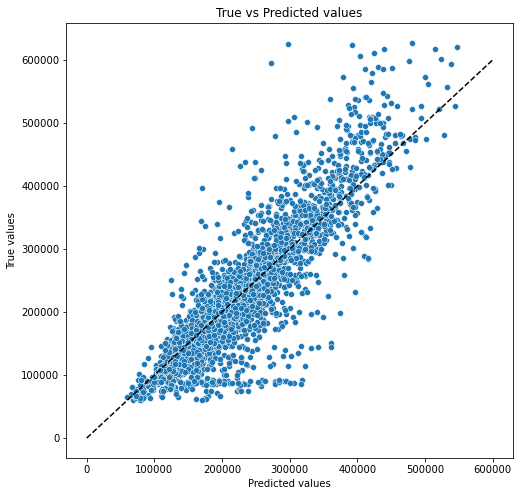

In [16]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

R2:	0.636
RMSE:	56518.245
MSE:	3194311977.975


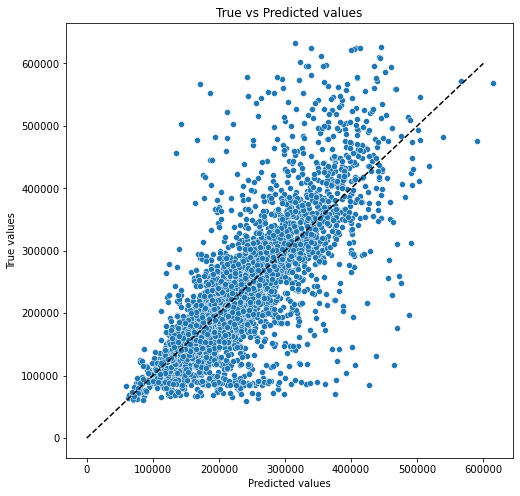

In [17]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [18]:
final_model.feature_importances_

array([0.09258683, 0.37809451, 0.03588112, 0.00302224, 0.00997972,
       0.01191058, 0.03744086, 0.14955721, 0.19272735, 0.03816778,
       0.0506318 ])

In [19]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [20]:
feature_importances.head(3)

,feature_name,importance
1,Square,0.378095
8,Social_2,0.192727
7,Social_1,0.149557


In [21]:
feature_importances.tail(3)

,feature_name,importance
5,Floor,0.011911
4,KitchenSquare,0.009980
3,BathroomSquare,0.003022


In [22]:
feature_importances.to_csv('D:/Учеба/NUMPY/feature_importances.csv', index=False)

In [27]:
SCALER_FILE_PATH = 'D:/Учеба/NUMPY/scaler.pkl'
MODEL_FILE_PATH = 'D:/Учеба/NUMPY/model.pkl'

In [30]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [31]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [32]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

GradientBoostingRegressor(criterion='mse', min_samples_leaf=7, n_estimators=400,
                          random_state=42)